# Identifying "reasonable" parameter space for Pf-tent
In this work, I want to figure out my power to identify loci at which I can build immunity, depending on number of antigens, weight of antigens, number of loci, etc. However, I'm not sure what range of these variables even results in a reasonable model, so I'm going to explore parameter space to identify model "reasonableness".

As the outcome for reasonableness, I'll be using the following calculated per person:
- mean parasite density
- mean infection length
- mean moi
- % of time with parasitemia
- malaria cases per year
- time between first asymptomatic & last symptomatic
- average parasite density between first asymptomatic & last symptomatic
- age at first asymptomatic
- age at last asymptomatic

In [1]:
import pfTent as tent
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import time

In [2]:
def get_peaks(pdensity):
    '''
    Finds the time of all parasite density peaks
    '''
    lag = np.pad(pdensity,1,mode='constant')[:-2]
    sign = np.sign(pdensity-lag).astype(int)
    lead = np.pad(sign,(0,1), mode='constant')[1:]
    peak = np.where(sign > lead)[0]
    return peak

def get_asymptomatics(peaks, malaria):
    '''
    Returns peaks for asymptomatic cases
    '''
    asymps = []
    for peak in peaks:
        if peak not in malaria:
            asymps.append(peak)
    return asymps

def get_spacing(asymps, malaria):
    '''
    Returns time window between first asymptomatic case & last symptomatic case
    '''
    diff = malaria[-1] - asymps[0]
    return diff

def get_intermediate_density(peaks, asymps, malaria, pdensity):
    '''
    Returns mean peak parasite density between first asymptomatic & last symptomatic
    '''
    window = [peak for peak in peaks if peak >= asymps[0] and peak <= malaria[-1]]
    pdensities = [pdensity[time] for time in window]
    mean = np.average(pdensities)
    return mean

def create_weight_alleles(loci, alleles):
    '''
    Returns weight & allele vectors.
    '''
    starter = np.ones(loci)
    zero = np.zeros(1)
    a = alleles * np.append(np.ones(1), starter)
    a = a.astype(int)
    strain = starter * (1/loci)
    w = np.append(np.zeros(2), strain)
    return a, w

In [3]:
y=5 # Simulate for 5 years
a = [5,5,5,5] # control,antigenic loci 1, antigenic loci 2, antigenic loci 3
w = [0,0,0.333333,0.3333333,0.333333] # general immunity, control, antigenic loci 1, antigenic loci 2, antigenic loci 3
n_people = 100
fever, breaks = tent.load_data()
eir=40

In [4]:
pmatrix, smatrix, imatrix, ivector, malaria = tent.simulate_person(y,a,w,fever,breaks)

NameError: name 'create_gen_imm' is not defined

In [5]:
pdensity = pmatrix[0,:,:].sum(axis=0)

In [6]:
peaks = get_peaks(pdensity)

In [7]:
asymps = get_asymptomatics(peaks,malaria)

In [8]:
get_spacing(asymps, malaria)

149

In [9]:
get_intermediate_density(peaks,asymps,malaria,pdensity)

27662.233334337932

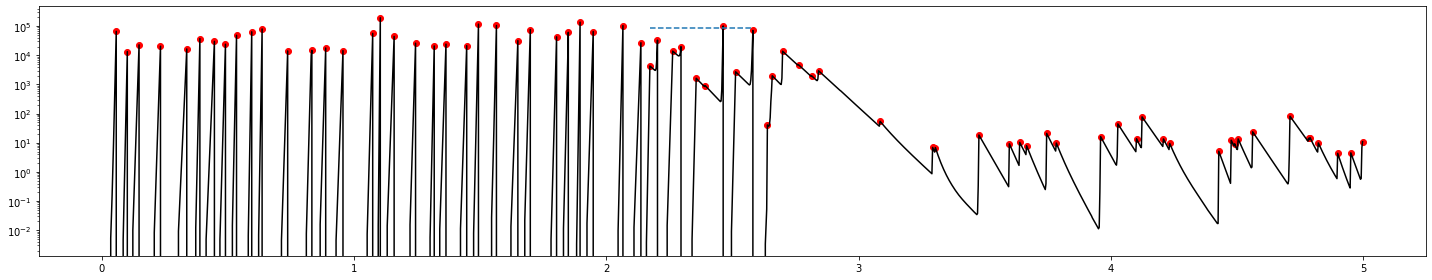

In [10]:
peak_values = []
for time in peaks:
    peak_values.append(pdensity[time])
    
window = [asymps[0]/365, malaria[-1]/365]

fig, ax = plt.subplots(tight_layout=True, figsize=(20,4))
ax.plot(np.arange(y*365)/365, pdensity,color="black")
ax.scatter(peaks/365, peak_values, color='red')
ax.set_yscale('log')
ax.plot(window,[83637,83637], linestyle='dashed')


(0.75, 1.5)

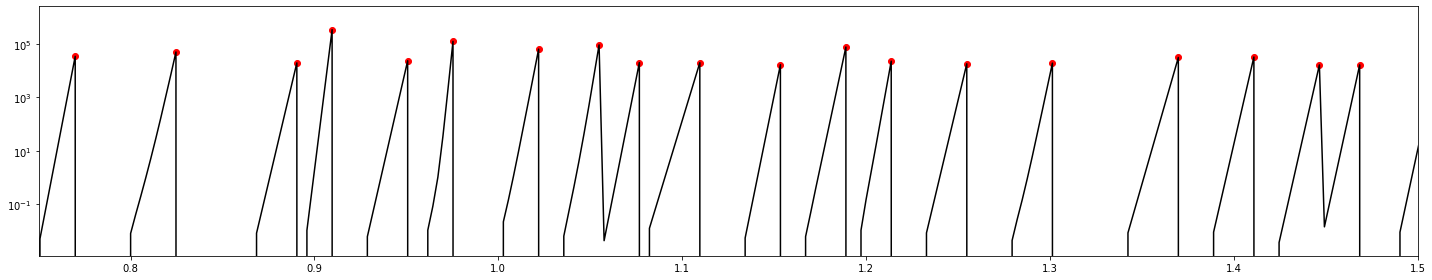

In [11]:
fig, ax = plt.subplots(tight_layout=True, figsize=(20,4))
ax.plot(np.arange(y*365)/365, pdensity,color="black")
ax.scatter(peaks/365, peak_values, color='red')
ax.set_yscale('log')
ax.plot(window,[83637,83637], linestyle='dashed')
ax.set_xlim([0.75,1.5])

Peak only looks weird because treatment threshold is daily calculated, so it gets treated because above threshold that day. Really should redefine treatment.

But peaks are in the right spot!! Woohoo!!

Average peak density is a little weird because pdensity is best interepret on the log scale. Consider revisiting this.

But for now, let's try this applied to a bunch of values.

## Banding the number of antigenic loci

In [248]:
y=5 # Simulate for 5 years
n_people = 100
outcomeLabels = ["Median parasite density",
                 "Mean parasite density",
                 "Median infection length",
                 "Mean infection length",
                 "Median MOI",
                 "Mean MOI",
                 "Percent with parasitemia",
                 "Malaria cases",
                 "Day of first asymptomatic",
                 "Day of last malaria",
                 "Days between first asymptomatic & last malaria",
                 "Average parasite density peaks between first asymptomatic & last malaria"
                ]
outcomeLog = [True, True, False, False, False, False, False, False, False, False, False, True]


In [160]:
n_iterations = 100 # 1 to 100 loci

In [245]:
outcomes = np.empty((len(outcomeLabels),n_people,n_iterations))

for loci in range(1,n_iterations+1):
    start = time.time()
    a,w = create_weight_alleles(loci,3) #0.0015
    for person in range(n_people):
        pmatrix, smatrix, imatrix, ivector, malaria = tent.simulate_person(y,a,w) # FAST
        
        Parasitemia, perPositivity = tent.check_parasitemia(y,pmatrix)
        outcomes[0,person,loci-1] = np.median(Parasitemia)
        outcomes[1,person,loci-1] = np.mean(Parasitemia)
        
        infectionlengths = tent.check_infection_length(smatrix,y)
        outcomes[2,person,loci-1] = np.median(infectionlengths)
        outcomes[3,person,loci-1] = np.mean(infectionlengths)
        
        MOI = tent.check_moi(y,smatrix)
        outcomes[4,person,loci-1] = np.median(MOI)
        outcomes[5,person,loci-1] = np.mean(MOI)
        
        outcomes[6,person,loci-1] = perPositivity
        outcomes[7,person,loci-1] = len(malaria)
        
        pdensity = pmatrix[0,:,:].sum(axis=0)
        peaks = get_peaks(pdensity)
        asymps = get_asymptomatics(peaks,malaria)
        outcomes[8,person,loci-1] = asymps[0]
        outcomes[9,person,loci-1] = malaria[-1]
        outcomes[10,person,loci-1] = get_spacing(asymps, malaria)
        outcomes[11,person,loci-1] = get_intermediate_density(peaks,asymps,malaria,pdensity)
    end = time.time()
    print(end-start)

19.43718194961548
20.854431867599487
22.23026990890503
22.96072769165039
24.60954976081848
25.420753955841064
26.393419981002808
28.02643895149231
28.830663919448853
29.915773153305054
31.008553981781006
32.479045152664185
33.26858925819397
34.76216387748718
36.4105179309845
36.86489701271057
37.79988479614258
38.830549001693726
40.18460011482239
41.136935234069824
42.25763130187988
44.11841583251953
48.252201080322266
47.22928786277771
46.87489700317383
47.91704201698303
48.953667879104614
50.58101201057434
52.100696086883545
52.71869707107544
53.353516817092896
54.48806405067444
55.383188009262085
56.755436182022095
58.089592695236206
59.02212905883789
59.924360036849976
61.06766676902771
61.95608878135681
63.119982957839966
64.2241268157959
64.90868306159973
66.11150789260864
67.48808217048645
1074.5085558891296
69.25342988967896
70.07658982276917
71.3921549320221
72.98939108848572
82.7244930267334
111.18204402923584
97.8251121044159
87.64314317703247
93.0295979976654
97.90998125076

KeyboardInterrupt: 

In [269]:
lowess = sm.nonparametric.lowess
loci_to_plot = np.repeat(np.arange(1,92),100)

def plot(arr, label, log):
    '''
    Plots results of banding
    '''
    flattened = arr[:,:91].flatten('F')
    smoothed = lowess(flattened, loci_to_plot, return_sorted=False, frac=0.25)

    fig, ax = plt.subplots(tight_layout=True, figsize=(8,8))
    ax.scatter(loci_to_plot, flattened, alpha=0.3, color='blue')
    ax.plot(loci_to_plot, smoothed, color='black')
    if log == True:
        ax.set_yscale('log')
    ax.set_xlabel('# of antigenic loci')
    ax.set_ylabel(label)

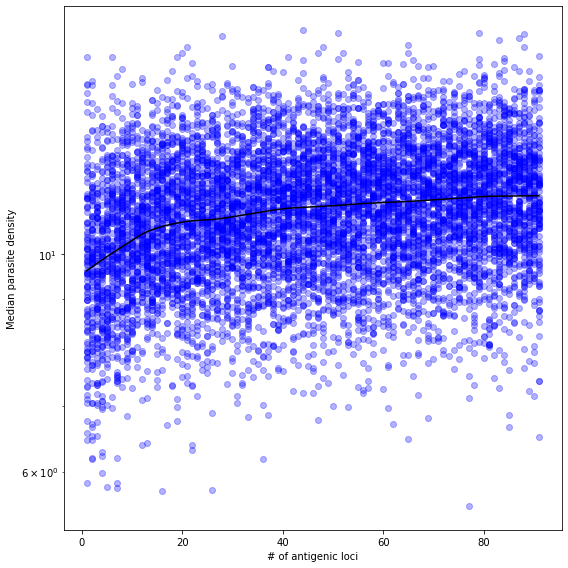

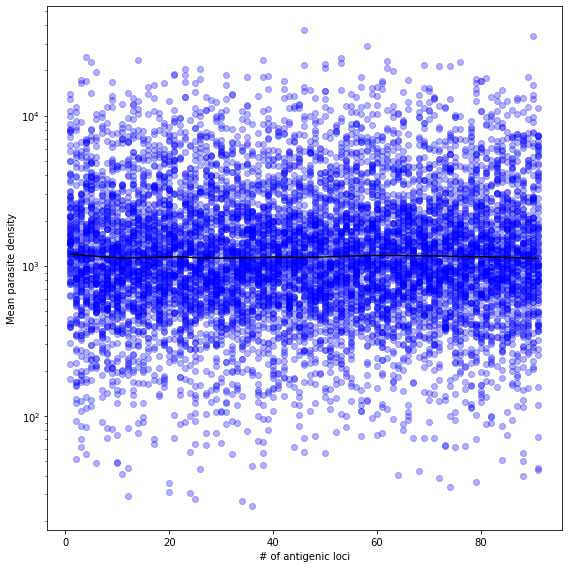

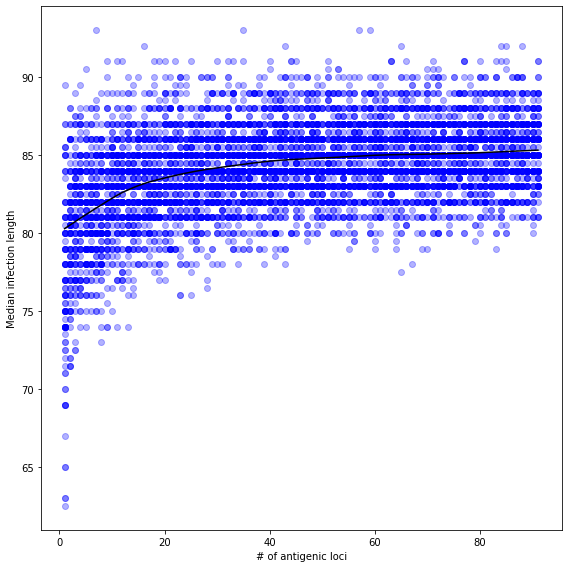

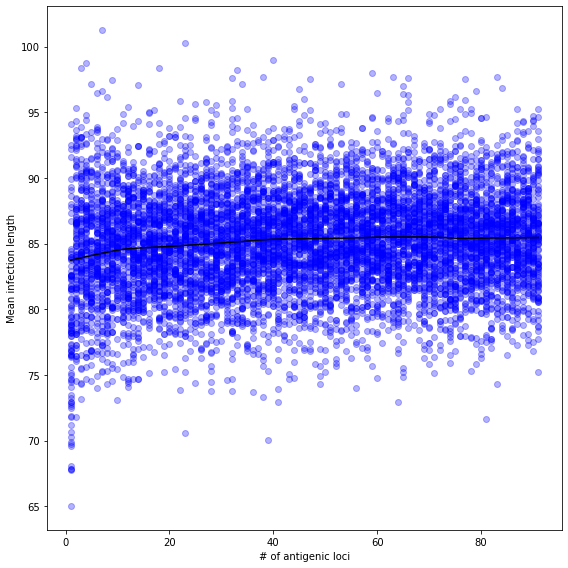

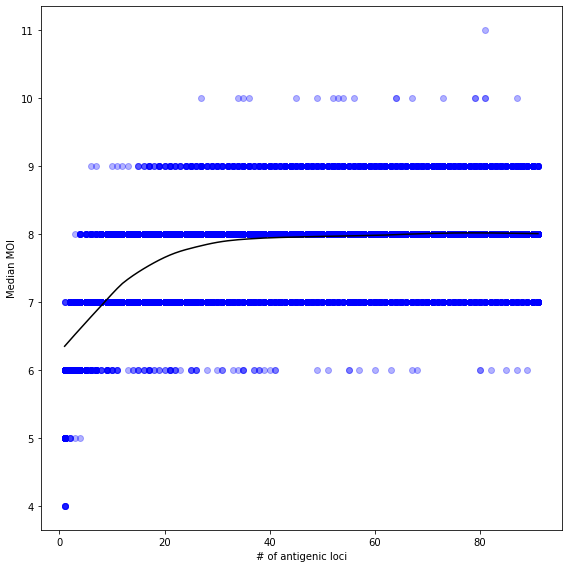

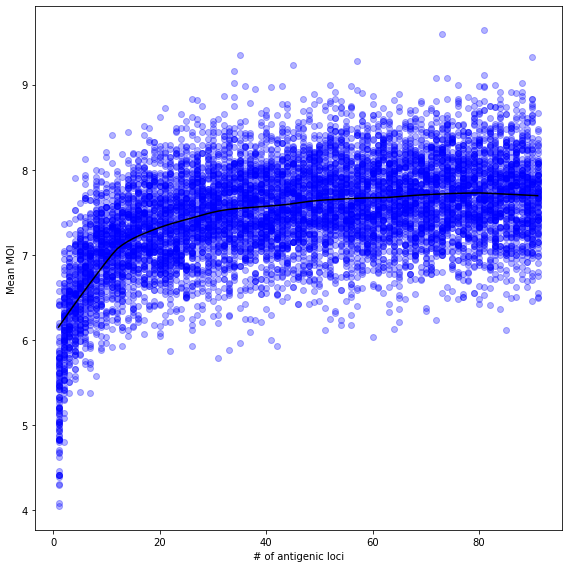

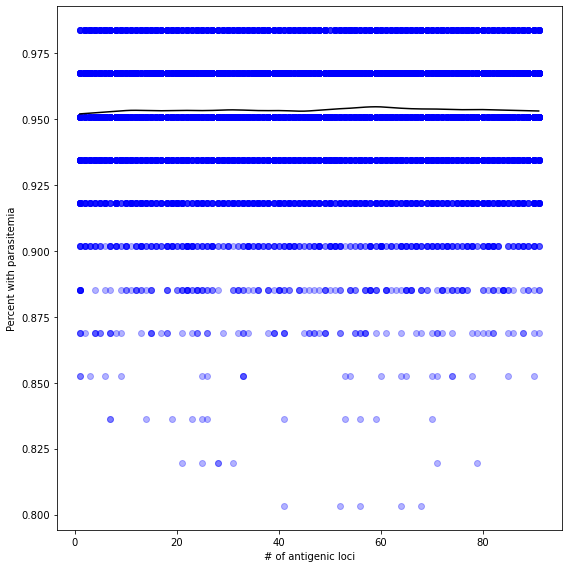

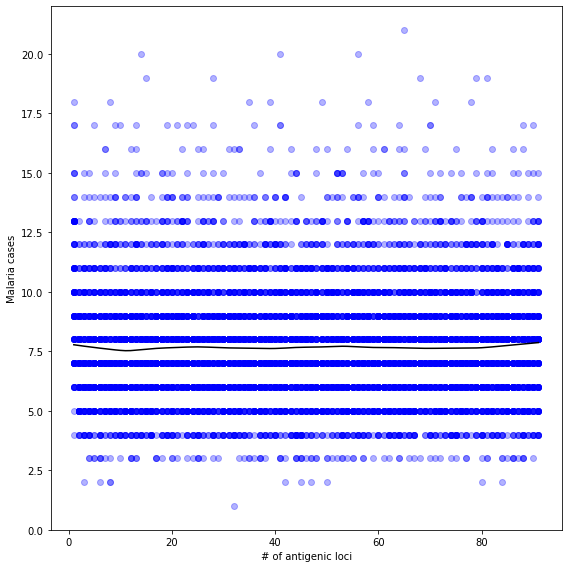

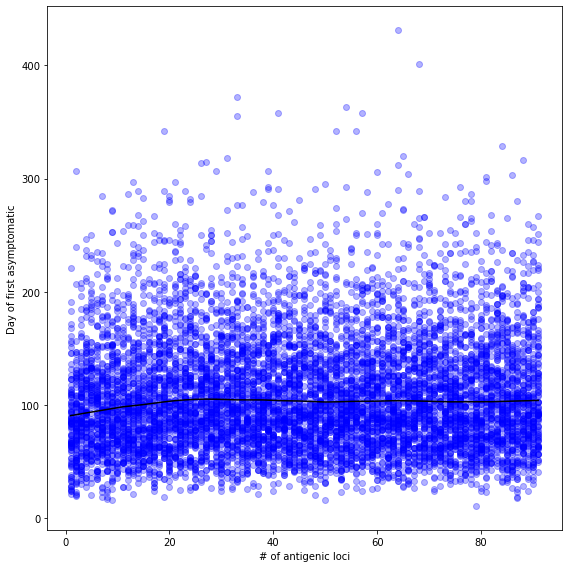

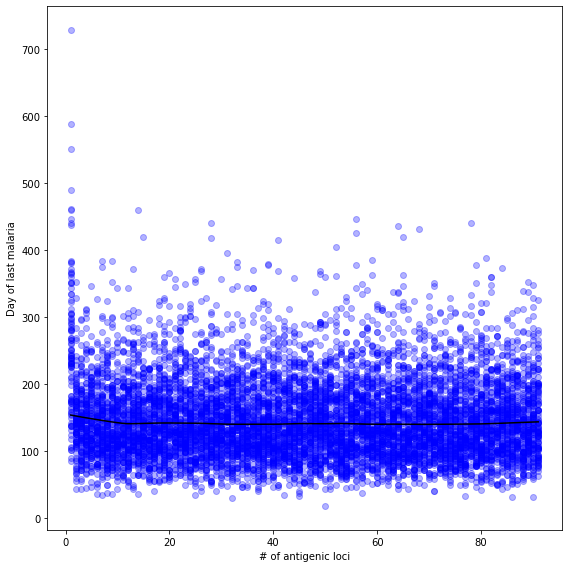

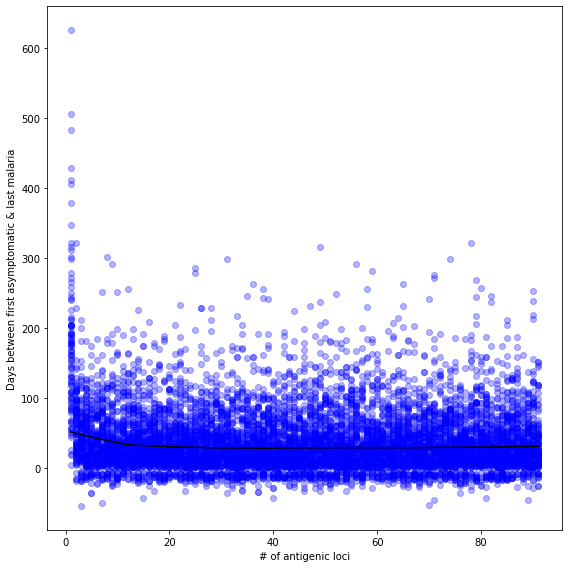

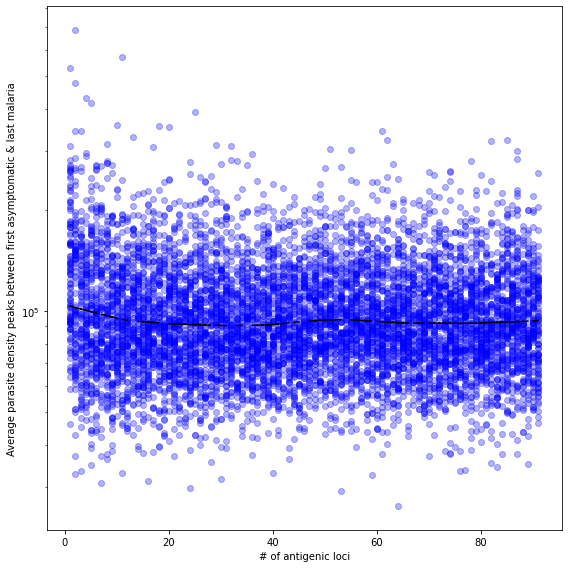

In [270]:
for row, lab, flag in zip(range(len(outcomeLabels)), outcomeLabels, outcomeLog):
    plot(outcomes[row,:,:], lab, flag)


In [266]:
np.set_printoptions(precision=3)
outcomes[:,0:5,90:91]

array([[[1.235e+01],
        [9.566e+00],
        [9.325e+00],
        [1.591e+01],
        [9.701e+00]],

       [[4.896e+02],
        [3.965e+02],
        [1.264e+03],
        [9.335e+02],
        [4.762e+02]],

       [[8.300e+01],
        [8.700e+01],
        [8.300e+01],
        [8.400e+01],
        [8.300e+01]],

       [[8.786e+01],
        [8.348e+01],
        [7.985e+01],
        [7.956e+01],
        [7.875e+01]],

       [[8.000e+00],
        [8.000e+00],
        [8.000e+00],
        [8.000e+00],
        [8.000e+00]],

       [[8.082e+00],
        [7.197e+00],
        [7.410e+00],
        [7.574e+00],
        [7.311e+00]],

       [[9.836e-01],
        [9.180e-01],
        [9.180e-01],
        [9.180e-01],
        [9.016e-01]],

       [[4.000e+00],
        [7.000e+00],
        [1.100e+01],
        [1.300e+01],
        [1.300e+01]],

       [[9.100e+01],
        [1.640e+02],
        [7.100e+01],
        [2.510e+02],
        [1.240e+02]],

       [[1.020e+02],
        [2.000e+